In [1]:
'''
Segment the OASIS brain data set with an Improved UNet.

@author Aghnia Prawira (45610240)
'''

import data_processing as dp
import improved_unet as iu

import os
import matplotlib.pyplot as plt

Tensorflow version: 2.1.0


In [2]:
dp.test()
iu.test()

Testing data processing.
Testing improved unet.


In [3]:
# Set path to dataset
dataset_path = "keras_png_slices_data/"

seg_test_path = dataset_path + "keras_png_slices_seg_test/"
seg_train_path = dataset_path + "keras_png_slices_seg_train/"
seg_val_path = dataset_path + "keras_png_slices_seg_validate/"
test_path = dataset_path + "keras_png_slices_test/"
train_path = dataset_path + "keras_png_slices_train/"
val_path = dataset_path + "keras_png_slices_validate/"

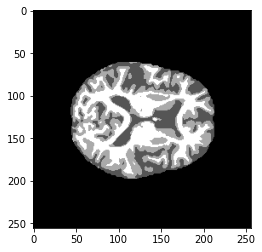

In [4]:
# Load images
seg_test = dp.load_image(seg_test_path)
seg_train = dp.load_image(seg_train_path)
seg_val = dp.load_image(seg_val_path)
test = dp.load_image(test_path)
train = dp.load_image(train_path)
val = dp.load_image(val_path)

single_image = seg_test[1]
plt.imshow(single_image)

In [19]:
from importlib import reload
reload(dp)
palette = dp.palette(single_image)

In [21]:
print(dp.one_hot(palette, single_image))

tf.Tensor(
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]], shape=(256, 256), dtype=bool)
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(256, 256), dtype=bool)
tf.Tensor(
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]], shape=(256, 256), dtype=bool)
tf.Tensor(
[[False False False ... False False False]
 [False False False ... Fals